# Preparation

## Loading libraries

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


plt.style.use('seaborn-bright')
plt.rc('font', size=15) 
colors = ["#1f18da", "#e42d5b", "#00d8a3", "#313131", "#ffb92a"]
sns.set_palette(sns.color_palette(colors))

## Load data

In [363]:
df = pd.read_csv(
    "./coffee-modified.csv", sep=",")

print("Elements: {}".format(df.size))
print("Shape: {}".format(df.shape))

Elements: 58036
Shape: (1319, 44)


## Look at data

In [364]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1312 non-null   object 
 1   Species                1319 non-null   object 
 2   Owner                  1310 non-null   object 
 3   Country.of.Origin      1316 non-null   object 
 4   Farm.Name              961 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1007 non-null   object 
 7   ICO.Number             1169 non-null   object 
 8   Company                1105 non-null   object 
 9   Altitude               1092 non-null   object 
 10  Region                 1257 non-null   object 
 11  Producer               1084 non-null   object 
 12  Number.of.Bags         1314 non-null   object 
 13  Bag.Weight             1314 non-null   object 
 14  In.Country.Partner     1314 non-null   object 
 15  Harv

In [365]:
pd.set_option("max_columns", 100)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318
ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,11/23/0101,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1312
Species,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,...,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,"unex guatemala, s.a.",Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica
Owner,metad plc,metad plc,grounds for health admin,yidnekachew dabessa,metad plc,ji-ae ahn,hugo valdivia,ethiopia commodity exchange,ethiopia commodity exchange,diamond enterprise plc,mohammed lalo,cqi q coffee sample representative,cqi q coffee sample representative,grounds for health admin,ethiopia commodity exchange,cqi q coffee sample representative,grounds for health admin,ethiopia commodity exchange,yunnan coffee exchange,essencecoffee,cqi q coffee sample representative,the coffee source inc.,roberto licona franco,cqi q coffee sample representative,ji-ae ahn,nucoffee,ethiopia commodity exchange,kabum trading company,bismarck castro,"lin, che-hao krude ???",nora zeas,specialty coffee-korea,nucoffee,francisco a mena,hider abamecha,daniel magu,kona pacific farmers cooperative,kona pacific farmers cooperative,ethiopia commodity exchange,cqi q coffee sample representative,itdp international,jacques pereira carneiro,jacques pereira carneiro,"lin, che-hao krude ???",jungle estate,nucoffee,great lakes coffee uganda,lusso lab,lusso lab,afca,...,juan luis alvarado romero,homero antonio de anda andrade,juan luis alvarado romero,juan luis alvarado romero,eileen koyanagi,eileen koyanagi,israel eduardo paz garcia,william ho,guillermo eduardo bobadilla muguira,cafes finos de exportacion s de r.l.,ana gonzales,volcafe ltda. - brasil,juan luis alvarado romero,juan luis alvarado romero,juana rodriguez gutierrez,francisco hernandez lorenzo,montegrande,martin jimenez casiano,"grupo juvenil magtayani, ac",israel eduardo paz garcia,pablo enrique martinez gama,juan luis alvarado romero,juan luis alvarado romero,NaN,nestor mendez gomez,eileen koyanagi,juan luis alvarado romero,jorge octavio escamilla prado,myrna roxana galvez gonzalez,eugene holman pew,kona pacific farmers cooperative,bourbon specialty coffees,cafes finos de exportacion s de r.l.,kurt kappeli,honor dela fuente,eileen koyanagi,myriam kaplan-pasternak,santa laura exportadora de cafe s.l.e.c. s.a.,jose armando norberto borzani lemini,ricardo aaron sampieri marini,kurt kappeli,volcafe ltda. - brasil,cadexsa,cadexsa,cadexsa,juan carlos garcia lopez,myriam kaplan-pasternak,"exportadora atlantic, s.a.",juan luis alvarado romero,bismarck castro
Country.of.Origin,Ethiopia,Ethiopia,Guatemala,Ethiopia,Ethiopia,Brazil,Peru,Ethiopia,Ethiopia,Ethiopia,Ethiopia,United States,United States,United St

## Clean data

### Defining cleaning functions

In [366]:
def copy_df(df):
    df_copy = df.copy()
    return df_copy

In [430]:
def drop_rows_with_undefined_vals(df, col):
    entries_before = df.shape[0]
    df.dropna(subset=[col], inplace=True)
    entries_after = df.shape[0]
    print("Removed {} entries containing undefined or missing values.".format(entries_before - entries_after))

    return df


In [431]:
def select_only_species(df, species):
    entries_before = df.shape[0]
    df = df[df.Species == species]
    entries_after = df.shape[0]
    print("Removed {} entries not being of Species {}.".format(entries_before - entries_after, species))
    return df

In [480]:
def drop_unnecessary_cols(df, cols):
    df = df.drop(labels=cols, axis=1)
    return df

In [481]:
def convert_to_string(df, col):
    df[col] = df[col].astype('|S')
    return df

In [482]:
def convert_to_float(df, col):
    df[col] = df[col].astype('float64')
    return df


In [483]:
def correct_altitude_values(df):
    #select row whrere region is of type cerrado and altitude is higher than 5000; move comma by one position to land in correct range (decimeter -> meter)
    df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df.Region == "cerrado") & (df["altitude_mean_meters"] > 5000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 10

    #take every row above 6000 meters and convert from cm to meters by dividing by 100
    df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] = df.loc[(df["altitude_mean_meters"] > 6000), ["altitude_mean_meters", "altitude_low_meters", "altitude_high_meters"]] / 100
    return df

In [484]:
def remove_zero_total_cup_results(df):
    entries_before = df.shape[0]
    df = df[df["Total.Cup.Points"] > 0]
    entries_after = df.shape[0]
    print("Removed {} entries where total cup results were equal to zero".format(entries_before - entries_after))
    return df

### Piping dataframe through cleaning functions

In [491]:
df_type_adjusted = (df.pipe(copy_df)
                    .pipe(drop_rows_with_undefined_vals, "Body")
                    .pipe(drop_rows_with_undefined_vals, "Balance")
                    .pipe(drop_rows_with_undefined_vals, "Uniformity")
                    .pipe(drop_rows_with_undefined_vals, "Clean.Cup")
                    .pipe(drop_rows_with_undefined_vals, "Sweetness")
                    .pipe(drop_rows_with_undefined_vals, "Cupper.Points")
                    .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                    .pipe(convert_to_string, "Country.of.Origin")
                    .pipe(convert_to_float, "Cupper.Points")
                    .pipe(convert_to_float, "altitude_mean_meters")
                    .pipe(convert_to_float, "Total.Cup.Points")
                    )
print("New data shape: {}".format(df_type_adjusted.shape))

unnecessary_cols = ["Lot.Number", "Farm.Name", "Mill", "Company", "Altitude", "Producer", "In.Country.Partner", "Owner.1", "Certification.Address", "Certification.Contact", "Owner", "Certification.Body"]

df_cleaned = (df.pipe(copy_df)
                .pipe(drop_unnecessary_cols, unnecessary_cols)
                .pipe(drop_rows_with_undefined_vals, "Body")
                .pipe(drop_rows_with_undefined_vals, "Balance")
                .pipe(drop_rows_with_undefined_vals, "Uniformity")
                .pipe(drop_rows_with_undefined_vals, "Clean.Cup")
                .pipe(drop_rows_with_undefined_vals, "Sweetness")
                .pipe(drop_rows_with_undefined_vals, "Cupper.Points")
                .pipe(drop_rows_with_undefined_vals, "Total.Cup.Points")
                .pipe(select_only_species, "Arabica")
                .pipe(convert_to_string, "Country.of.Origin")
                .pipe(convert_to_float, "altitude_mean_meters")
                .pipe(convert_to_float, "Cupper.Points")
                .pipe(convert_to_float, "Total.Cup.Points")
                .pipe(remove_zero_total_cup_results)
                .pipe(correct_altitude_values)
              )
print("New data shape: {}".format(df_cleaned.shape))


Removed 10 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 2 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
New data shape: (1307, 44)
Removed 10 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 2 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries containing undefined or missing values.
Removed 0 entries not being of Species Arabica.
Removed 1 entries where total cup results were equal to zero
New data shape: (1306, 32)


## Look at data after cleaning

In [492]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1317
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1306 non-null   object 
 1   Species               1306 non-null   object 
 2   Country.of.Origin     1306 non-null   |S28   
 3   ICO.Number            1161 non-null   object 
 4   Region                1249 non-null   object 
 5   Number.of.Bags        1306 non-null   object 
 6   Bag.Weight            1306 non-null   object 
 7   Harvest.Year          1260 non-null   object 
 8   Grading.Date          1306 non-null   object 
 9   Variety               1105 non-null   object 
 10  Processing.Method     1155 non-null   object 
 11  Aroma                 1306 non-null   object 
 12  Flavor                1306 non-null   object 
 13  Aftertaste            1306 non-null   object 
 14  Acidity               1306 non-null   object 
 15  Body                 

In [493]:
df_cleaned.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317
ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310
Species,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,...,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica
Country.of.Origin,b'Ethiopia',b'Ethiopia',b'Guatemala',b'Ethiopia',b'Ethiopia',b'Brazil',b'Peru',b'Ethiopia',b'Ethiopia',b'Ethiopia',b'Ethiopia',b'United States',b'United States',b'United States (Hawaii)',b'Ethiopia',b'United States',b'Indonesia',b'Ethiopia',b'China',b'Ethiopia',b'United States',b'Costa Rica',b'Mexico',b'United States',b'Ethiopia',b'Brazil',b'Ethiopia',b'Uganda',b'Honduras',b'Taiwan',b'Nicaragua',"b'Tanzania, United Republic Of'",b'Brazil',b'Costa Rica',b'Ethiopia',b'Kenya',b'United States (Hawaii)',b'United States (Hawaii)',b'Ethiopia',b'United States',b'Thailand',b'Brazil',b'Brazil',b'Taiwan',b'Kenya',b'Brazil',b'Uganda',b'Colombia',b'Kenya',b'Uganda',...,b'Peru',b'India',b'Mexico',b'Guatemala',b'Mexico',b'Guatemala',b'Guatemala',b'United States (Hawaii)',b'United States (Hawaii)',b'Mexico',b'Indonesia',b'Mexico',b'Honduras',b'Philippines',b'Brazil',b'Guatemala',b'Guatemala',b'Mexico',b'Mexico',b'Mexico',b'Mexico',b'Mexico',b'Mexico',b'Mexico',b'Guatemala',b'Mexico',b'United States (Hawaii)',b'Guatemala',b'Mexico',b'Mexico',b'Mexico',b'United States (Hawaii)',b'Brazil',b'Honduras',b'Mexico',b'Colombia',b'United States (Hawaii)',b'Haiti',b'Costa Rica',b'Mexico',b'Mexico',b'Mexico',b'Brazil',b'Honduras',b'Honduras',b'Honduras',b'Mexico',b'Haiti',b'Nicaragua',b'Guatemala'
ICO.Number,2014/2015,2014/2015,NaN,NaN,2014/2015,NaN,NaN,010/0338,010/0338,2014/15,NaN,unknown,unknown,NaN,010/0338,unknown,NaN,010/0056,NaN,100181006,unknown,5-562-0015,0,unknown,NaN,002/1251/0073,010/0056/Sidamo,0,13-111-053,Taiwan,790-0013,A019116,002/1251/0068,5818009,2014/15,0,220452,HDOA 210128 Kona Fancy,010/0170,unknown,01-011-512,002/1352/0045,002/1352/0045,Taiwan,NIL,002/1251/0071,0,NONE,NONE,x,...,30,14/7/2015/172,016/2362/0051,11/23/01,0,11/23/0394,11/23/0101,KPBP 21114,Specialty Coffee Association,1405792248,1,1104372556,13-117-87,0,NaN,11/23/0768,11/23/0121,1207093598,2670,F07008657,3,0,0,1104362940,11/23/0122,016-2129,KPBP 022414,11/23/0796,1104355254,1104820070,0,220456,002/4542/0189,13-117-88,0016-2722-0001,3,KP 022014,NaN,5-545-0015,11111,1104351023,0016-2847-0001,NaN,13-63-174,13-63-174,13-63-174,1104328663,NaN,017-053-0211/ 017-053-0212,11/853/165
Region,guji-hambela,guji-hambela,NaN,oromia,guji-hambela,NaN,NaN,oromia,oromiya,"snnp/kaffa zone,gimbowereda",oromia,antioquia,antioquia,kona,oromiya,antioquia,sulawesi,yirgacheffe,yunnan,gedio,antioquia,sa

# Data analysis

## Distributions

### Countries

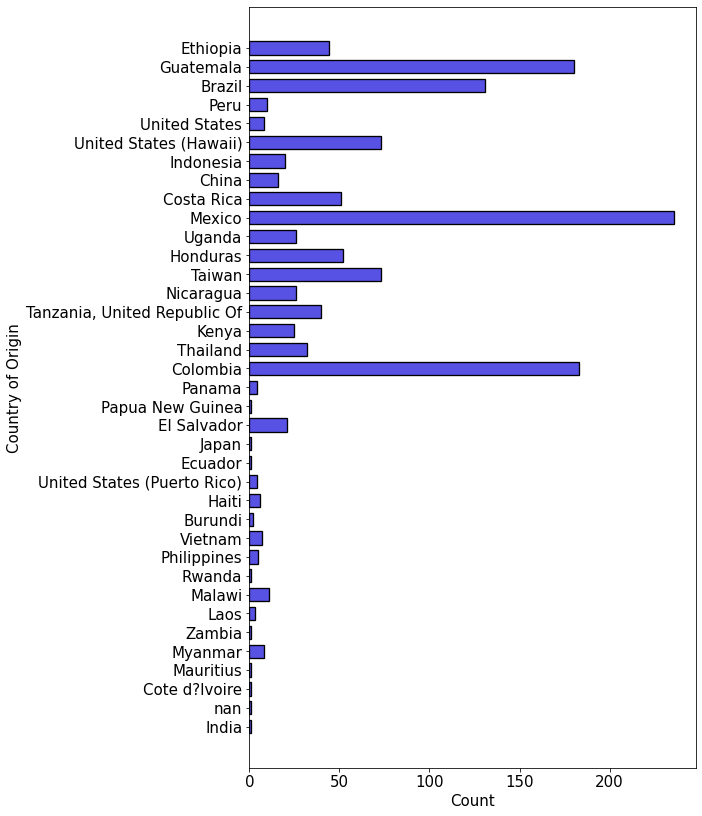

In [494]:
plt.figure(figsize=(8, 14))
ax = sns.histplot(data=df_cleaned, y="Country.of.Origin", shrink=.7);
ax.set(ylabel="Country of Origin");

### Altitude

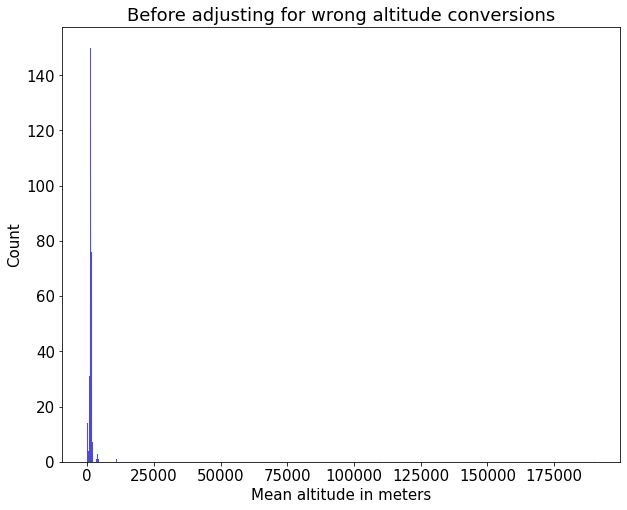

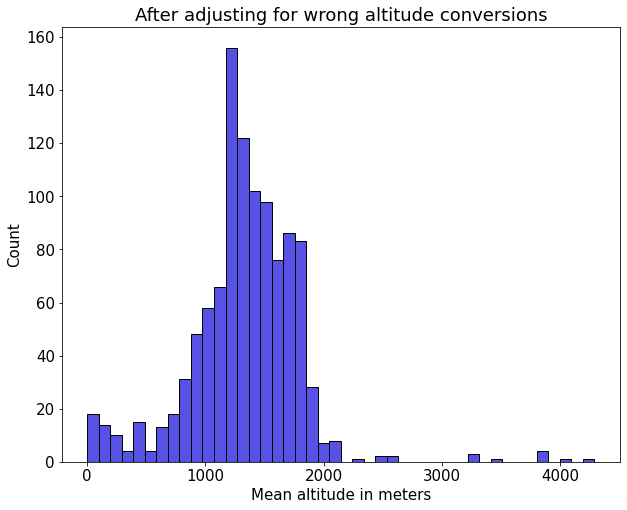

In [501]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="Before adjusting for wrong altitude conversions");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="altitude_mean_meters")
ax.set(xlabel="Mean altitude in meters", title="After adjusting for wrong altitude conversions");

### Cupping results

Overall average of tested beans: 82.18681470137827
Overall standard deviation of tested beans: 2.681657940472538
Minimum of tested beans: 59.83
Maximum of tested beans: 90.58


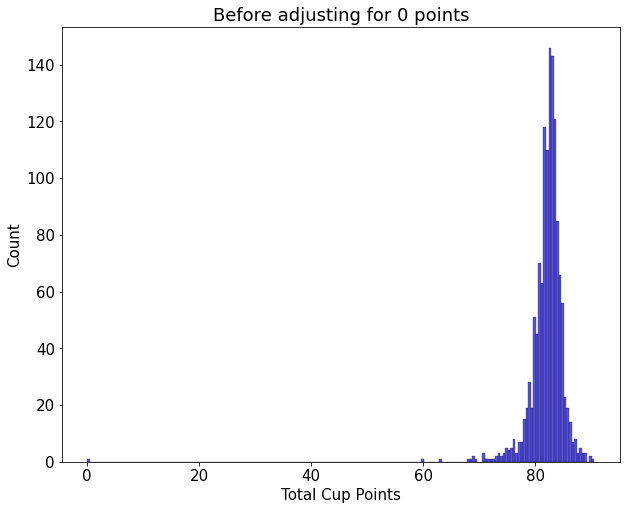

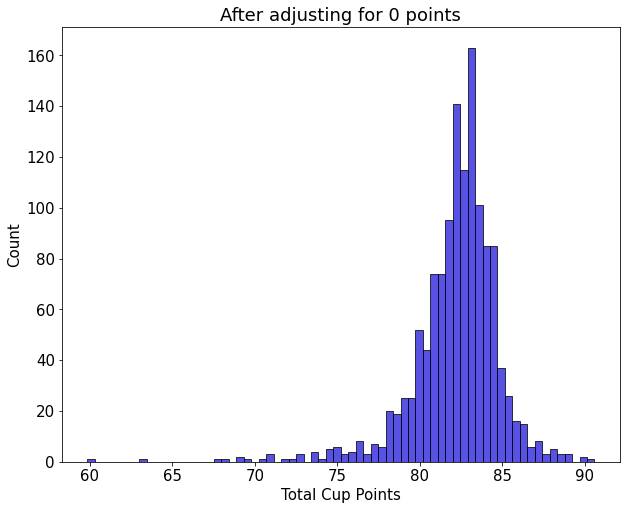

In [502]:
print("Overall average of tested beans: {}".format(df_cleaned["Total.Cup.Points"].mean()))
print("Overall standard deviation of tested beans: {}".format(df_cleaned["Total.Cup.Points"].std()))
print("Minimum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].min()))
print("Maximum of tested beans: {}".format(df_cleaned["Total.Cup.Points"].max()))

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_type_adjusted, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="Before adjusting for 0 points");

plt.figure(figsize=(10, 8))
ax = sns.histplot(data=df_cleaned, x="Total.Cup.Points")
ax.set(xlabel="Total Cup Points", title="After adjusting for 0 points");